In [1]:
###########################################################################
###### ANÁLISIS DE CORRELACIÓN DE PEARSON #################################
#########################################################################

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import os
from sklearn.metrics import mean_squared_error
from scipy.stats import mannwhitneyu

In [2]:
# Leer los archivos de Excel en dataframes de pandas
df_ideam = pd.read_excel('datos_analisis\precipitacion_mensual_ideam.xlsx')
df_chirps = pd.read_excel('datos_analisis\pp_mes_chirps.xlsx')

print(df_ideam.shape)
print(df_chirps.shape)

(528, 227)
(528, 227)


In [3]:
# --- Procesamiento de fechas ---
df_ideam['Fecha'] = pd.to_datetime(df_ideam['Fecha'])
df_chirps['Fecha'] = pd.to_datetime(df_chirps['Fecha'])

df_ideam.set_index('Fecha', inplace=True)
df_chirps.set_index('Fecha', inplace=True)

# --- DataFrame para resultados y carpeta de salida ---
results = pd.DataFrame(columns=['Estacion', 'Correlacion', 'R2', 'p-value'])
output_folder = 'validacion'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# --- Bucle para calcular la correlación para cada estación ---
for column in df_ideam.columns:
    # Combinar los datos de la estación actual de ambos DataFrames
    combined = pd.concat([df_ideam[column], df_chirps[column]], axis=1)
    combined.columns = ['IDEAM', 'CHIRPS']
    
    # Eliminar filas donde falte algún dato para asegurar una comparación justa
    combined.dropna(inplace=True)

    # Si no quedan datos comunes después de limpiar, se salta a la siguiente estación
    if combined.empty:
        print(f"Advertencia: No hay datos comunes para la estación: {column}. Se omitirá.")
        continue

    # Calcular la correlación de Spearman y el p-valor
    correlation, p_value = stats.spearmanr(combined['IDEAM'], combined['CHIRPS'])
    
    # Calcular el coeficiente de determinación (R²)
    R2 = correlation ** 2

    # Agregar los resultados al DataFrame de resultados
    new_row = pd.DataFrame({
        'Estacion': [column], 
        'Correlacion': [correlation], 
        'R2': [R2], 
        'p-value': [p_value]
    })
    results = pd.concat([results, new_row], ignore_index=True)

# --- Guardar el DataFrame de resultados en un archivo de Excel ---
output_path = os.path.join(output_folder, 'analisis-asociacion-estaciones.xlsx')
results.to_excel(output_path, index=False)

print(f"✅ ¡Análisis completado!")
print(f"Los resultados se han guardado en: {output_path}")

C:\Users\Miguel Rico\AppData\Local\Temp\ipykernel_55796\764966263.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


✅ ¡Análisis completado!
Los resultados se han guardado en: validacion\analisis-asociacion-estaciones.xlsx


In [ ]:
#########################################################################
###### ANÁLISIS DE DIFERENCIA (U DE MANN-WHITNEY) POR MES ############
#########################################################################

import pandas as pd
from scipy import stats
import os

# --- Carga y preparación de datos ---
# Asegúrate de que las rutas a tus archivos de Excel sean correctas.
try:
    df_ideam = pd.read_excel('datos_analisis/precipitacion_mensual_ideam.xlsx')
    df_chirps = pd.read_excel('datos_analisis/pp_mes_chirps.xlsx')
except FileNotFoundError:
    print("❌ Error: No se encontró uno o ambos archivos de Excel. Revisa las rutas.")
    exit() # Termina el script si los archivos no existen

# --- Procesamiento de fechas ---
df_ideam['Fecha'] = pd.to_datetime(df_ideam['Fecha'])
df_chirps['Fecha'] = pd.to_datetime(df_chirps['Fecha'])

df_ideam.set_index('Fecha', inplace=True)
df_chirps.set_index('Fecha', inplace=True)

# --- Crear DataFrame para resultados y carpeta de salida ---
results = pd.DataFrame(index=df_ideam.columns, columns=range(1, 13))
output_folder = 'validacion'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# --- Bucle para realizar la prueba estadística en cada estación y mes ---
for column in df_ideam.columns:
    # Combinar los datos de la estación actual
    combined = pd.concat([df_ideam[column], df_chirps[column]], axis=1)
    combined.columns = ['IDEAM', 'CHIRPS']
    
    # Eliminar filas con datos faltantes
    combined.dropna(inplace=True)

    # Realizar la prueba para cada mes
    for month in range(1, 13):
        ideam_month = combined[combined.index.month == month]['IDEAM']
        chirps_month = combined[combined.index.month == month]['CHIRPS']

        # Verificar si hay suficientes datos para la prueba
        if len(ideam_month) < 1 or len(chirps_month) < 1:
            results.loc[column, month] = None # Asignar None si no hay datos
            continue

        # Realizar la prueba U de Mann-Whitney (no paramétrica)
        try:
            u_stat, p_value = stats.mannwhitneyu(ideam_month, chirps_month, alternative='two-sided')
            # Agregar el valor p al DataFrame de resultados
            results.loc[column, month] = p_value
        except ValueError:
            # Esto puede ocurrir si todos los valores en una muestra son idénticos
            results.loc[column, month] = 1.0 # O considera asignar None


# --- Formatear y guardar los resultados ---
# Renombrar las columnas con los nombres de los meses
results.columns = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Guardar el DataFrame de resultados en un archivo de Excel
output_path = os.path.join(output_folder, 'analisis_diferencia.xlsx')
results.to_excel(output_path)

print(f"✅ ¡Análisis completado!")
print(f"Los resultados se han guardado en: {output_path}")

✅ ¡Análisis completado!
Los resultados se han guardado en: validacion\analisis_diferencia_U_Mann_Whitney.xlsx


In [1]:
#########################################################################
######       ANÁLISIS DE DIFERENCIA (T-STUDENT) POR MES      ############
#########################################################################

import pandas as pd
from scipy import stats
import os

# --- Carga y preparación de datos ---
# Asegúrate de que las rutas a tus archivos de Excel sean correctas.
try:
    df_ideam = pd.read_excel('datos_analisis/precipitacion_mensual_ideam.xlsx')
    df_chirps = pd.read_excel('datos_analisis/pp_mes_chirps.xlsx')
except FileNotFoundError:
    print("❌ Error: No se encontró uno o ambos archivos de Excel. Revisa las rutas.")
    exit() # Termina el script si los archivos no existen

# --- Procesamiento de fechas ---
df_ideam['Fecha'] = pd.to_datetime(df_ideam['Fecha'])
df_chirps['Fecha'] = pd.to_datetime(df_chirps['Fecha'])

df_ideam.set_index('Fecha', inplace=True)
df_chirps.set_index('Fecha', inplace=True)

# --- Crear DataFrame para resultados y carpeta de salida ---
results = pd.DataFrame(index=df_ideam.columns, columns=range(1, 13))
output_folder = 'validacion'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# --- Bucle para realizar la prueba estadística en cada estación y mes ---
for column in df_ideam.columns:
    # Combinar los datos de la estación actual
    combined = pd.concat([df_ideam[column], df_chirps[column]], axis=1)
    combined.columns = ['IDEAM', 'CHIRPS']
    
    # Eliminar filas con datos faltantes
    combined.dropna(inplace=True)

    # Realizar la prueba para cada mes
    for month in range(1, 13):
        ideam_month = combined[combined.index.month == month]['IDEAM']
        chirps_month = combined[combined.index.month == month]['CHIRPS']

        # Verificar si hay suficientes datos para la prueba
        # La prueba t necesita al menos 2 observaciones por grupo
        if len(ideam_month) < 2 or len(chirps_month) < 2:
            results.loc[column, month] = None # Asignar None si no hay suficientes datos
            continue

        # --- CAMBIO PRINCIPAL: Realizar la prueba t de Student ---
        try:
            # Se reemplaza stats.mannwhitneyu por stats.ttest_ind
            t_stat, p_value = stats.ttest_ind(ideam_month, chirps_month, equal_var=False) # Welch's t-test
            
            # Agregar el valor p al DataFrame de resultados
            results.loc[column, month] = p_value
        except ValueError:
            # Esto puede ocurrir si todos los valores en una muestra son idénticos
            results.loc[column, month] = 1.0 # O considera asignar None


# --- Formatear y guardar los resultados ---
# Renombrar las columnas con los nombres de los meses
results.columns = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Guardar el DataFrame de resultados en un archivo de Excel
output_path = os.path.join(output_folder, 'analisis_diferencia_ttest.xlsx')
results.to_excel(output_path)

print(f"✅ ¡Análisis con t-test completado!")
print(f"Los resultados se han guardado en: {output_path}")

✅ ¡Análisis con t-test completado!
Los resultados se han guardado en: validacion\analisis_diferencia_ttest.xlsx


C:\Users\Miguel Rico\AppData\Local\Temp\ipykernel_55796\3211861741.py:62: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


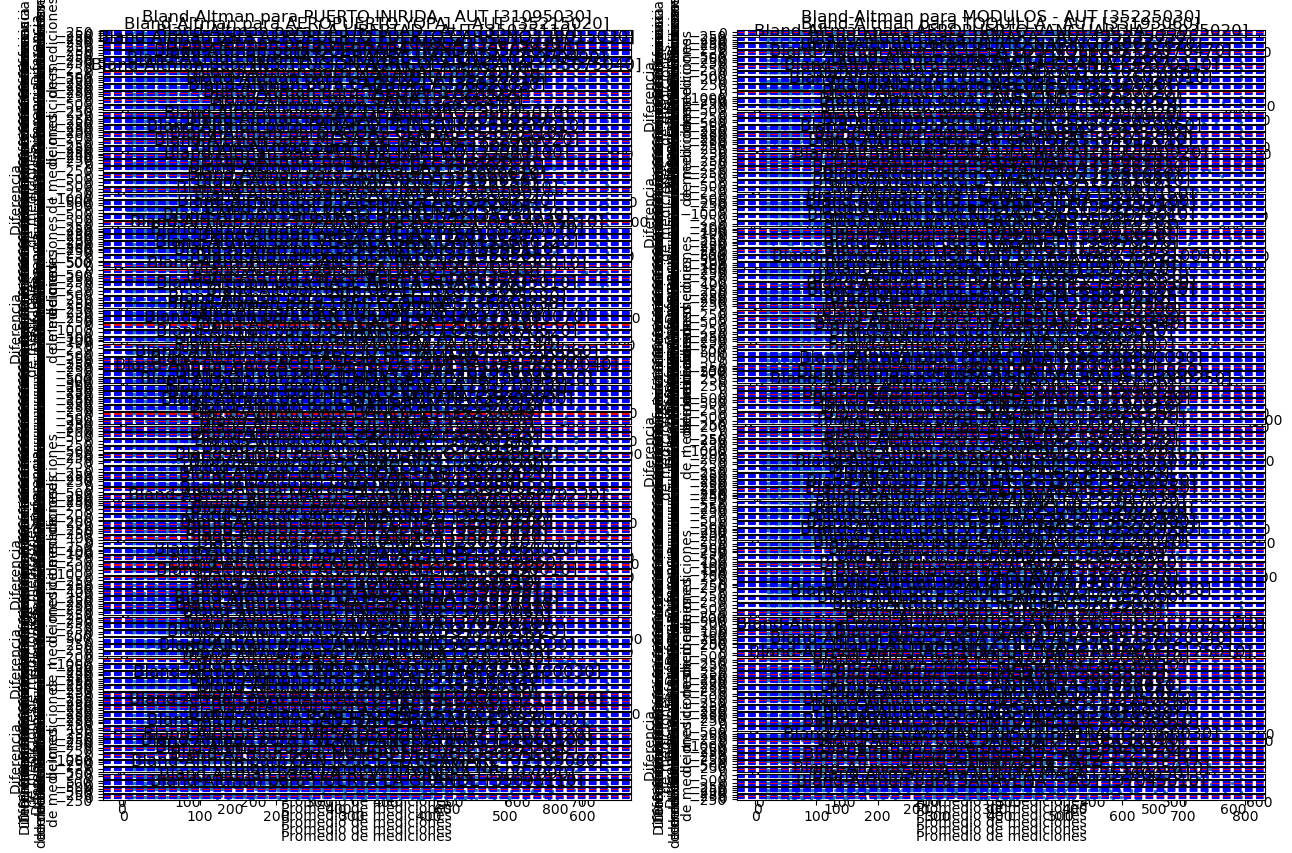

In [5]:
#########################################################################
###### ANÁLISIS DE ERROR Y SESGO #################################
#########################################################################

# Leer los archivos de Excel en dataframes de pandas
# Leer los archivos de Excel en dataframes de pandas
df_ideam = pd.read_excel('datos_analisis\precipitacion_mensual_ideam.xlsx')
df_chirps = pd.read_excel('datos_analisis\pp_mes_chirps.xlsx')

# Asegurarse de que 'Fecha' es una columna de fecha
df_ideam['Fecha'] = pd.to_datetime(df_ideam['Fecha'])
df_chirps['Fecha'] = pd.to_datetime(df_chirps['Fecha'])

# Configurar 'Fecha' como el índice
df_ideam.set_index('Fecha', inplace=True)
df_chirps.set_index('Fecha', inplace=True)

# Inicializar el dataframe de resultados
results_df = pd.DataFrame(index=df_ideam.columns, columns=["Bias", "MAD", "RMSE"])

# Configurar el tamaño del gráfico
#plt.figure(figsize=(15, 10))
fig = plt.figure(figsize=(15, 10))

# Configurar el número de gráficos por fila
n_cols = 2
n_rows = len(df_ideam.columns) // n_cols + (len(df_ideam.columns) % n_cols > 0)

# Calcular las métricas y los gráficos para cada estación
for i, column in enumerate(df_ideam.columns):
    plt.subplot(n_rows, n_cols, i + 1)

    # Combinar los datos de la estación de ambos conjuntos de datos
    combined = pd.concat([df_ideam[column], df_chirps[column]], axis=1)
    combined.columns = ['IDEAM', 'CHIRPS']

    # Eliminar las filas con datos faltantes
    combined.dropna(inplace=True)

    # Calcular el sesgo, la MAD y el RMSE
    bias = combined['CHIRPS'].subtract(combined['IDEAM']).mean()
    mad = combined['CHIRPS'].subtract(combined['IDEAM']).abs().mean()
    rmse = np.sqrt(mean_squared_error(combined['IDEAM'], combined['CHIRPS']))

    # Agregar los resultados al dataframe de resultados
    results_df.loc[column, "Bias"] = bias
    results_df.loc[column, "MAD"] = mad
    results_df.loc[column, "RMSE"] = rmse

    # Crear el gráfico de Bland-Altman
    mean = combined.mean(axis=1)
    diff = combined['CHIRPS'] - combined['IDEAM']
    plt.scatter(mean, diff, s=2)
    plt.axhline(bias, color='red', linestyle='--')  # Línea de sesgo
    plt.axhline(bias + 1.96 * diff.std(), color='blue', linestyle='--')  # Línea de limites de acuerdo
    plt.axhline(bias - 1.96 * diff.std(), color='blue', linestyle='--')  # Línea de limites de acuerdo
    plt.title(f'Bland-Altman para {column}')
    plt.xlabel('Promedio de mediciones')
    plt.ylabel('Diferencia \nde mediciones')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
# Mostrar el gráfico
plt.show()

fig.savefig("validacion/error.png", dpi=300, bbox_inches='tight', pad_inches=0.5, transparent=True)

# Guardar el dataframe de resultados en un nuevo archivo de Excel
results_df.to_excel('validacion/analisis-error.xlsx')
